Best parameters: {'classifier__C': 1, 'classifier__gamma': 0.1}
Accuracy: 0.8086321381142099
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.79      0.86     11360
           1       0.57      0.86      0.69      3700

    accuracy                           0.81     15060
   macro avg       0.76      0.83      0.78     15060
weighted avg       0.85      0.81      0.82     15060

Confusion Matrix:
 [[8998 2362]
 [ 520 3180]]


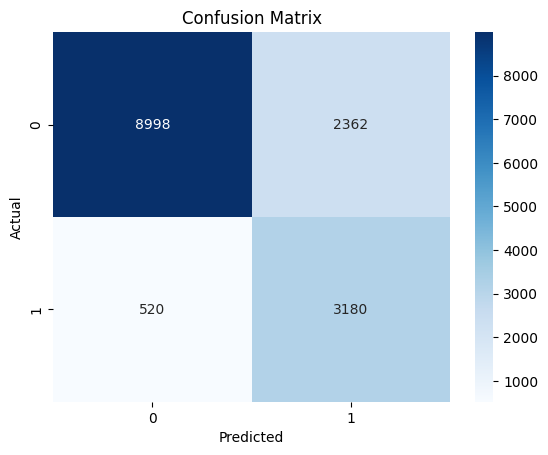

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

# Step 1: Load data (per problem statement, using provided CSVs)
try:
    train_df = pd.read_csv('SalaryData_Train(1).csv')
    test_df = pd.read_csv('SalaryData_Test(1).csv')
except FileNotFoundError:
    raise FileNotFoundError("Ensure SalaryData_Train(1).csv and SalaryData_Test(1).csv are in the working directory")

# Step 2: Handle missing values ('?' as per UCI Adult dataset convention)
train_df.replace(' ?', np.nan, inplace=True)  # Standardize missing value marker
test_df.replace(' ?', np.nan, inplace=True)

# Define features from problem statement
numerical_cols = ['age', 'educationno', 'capitalgain', 'capitalloss', 'hoursperweek']
categorical_cols = ['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'native']

# Impute missing values
num_imputer = SimpleImputer(strategy='median')  # Median for numerical stability
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode for categoricals

train_df[numerical_cols] = num_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])
test_df[numerical_cols] = num_imputer.transform(test_df[numerical_cols])
test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])

# Step 3: Prepare features and target
X_train = train_df.drop('Salary', axis=1)
y_train = train_df['Salary'].map({' <=50K': 0, ' >50K': 1})  # Binary encoding per problem statement
X_test = test_df.drop('Salary', axis=1)
y_test = test_df['Salary'].map({' <=50K': 0, ' >50K': 1})

# Step 4: Preprocessing pipeline (handles numerical scaling and categorical encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical features for SVM
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)  # Encode categoricals
    ])

# Step 5: SVM Pipeline (RBF kernel for non-linearity, balanced weights for class imbalance)
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])

# Step 6: Split train data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Step 7: Hyperparameter tuning (limited grid for efficiency)
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization parameter
    'classifier__gamma': ['scale', 0.1, 0.01]  # Kernel coefficient
}
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_split, y_train_split)

# Step 8: Train best model on full train data
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

# Step 9: Predict and evaluate on test data
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 10: Optional visualization (requires matplotlib/seaborn)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

scikit-learn version: 1.5.1
Data loaded successfully. Train shape: (30161, 14) Test shape: (15060, 14)
Subsampled train shape: (3016, 14)
Training time (subsampled): 0.08 seconds
Validation Accuracy: 0.7798013245033113
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.75      0.84       452
           1       0.54      0.86      0.66       152

    accuracy                           0.78       604
   macro avg       0.74      0.81      0.75       604
weighted avg       0.84      0.78      0.79       604

Training on full data...
Full training time: 1.05 seconds
Test Accuracy: 0.80132802124834
Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.79      0.86     11360
           1       0.56      0.85      0.68      3700

    accuracy                           0.80     15060
   macro avg       0.75      0.82      0.77     15060
weighted avg       0.85     

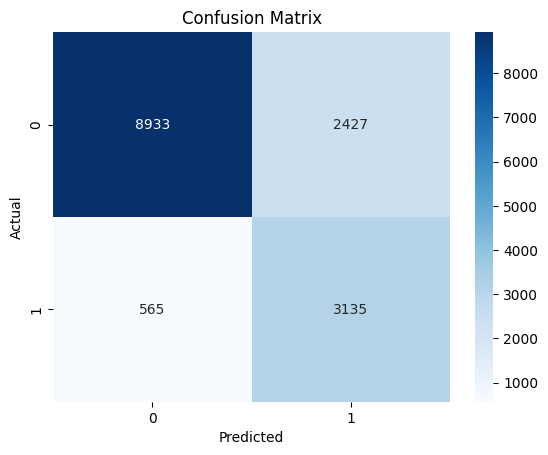

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import time
import sys
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")  # Debug: Verify library version

# Step 1: Check environment and load data
try:
    train_df = pd.read_csv('SalaryData_Train(1).csv')
    test_df = pd.read_csv('SalaryData_Test(1).csv')
    print("Data loaded successfully. Train shape:", train_df.shape, "Test shape:", test_df.shape)
except FileNotFoundError:
    print("Error: Ensure 'SalaryData_Train(1).csv' and 'SalaryData_Test(1).csv' are in the working directory")
    sys.exit(1)

# Step 2: Subsample for quick testing (10% of train data)
train_df = train_df.sample(frac=0.1, random_state=42)
print("Subsampled train shape:", train_df.shape)  # Debug: Confirm subsampling

# Step 3: Handle missing values
train_df.replace(' ?', np.nan, inplace=True)
test_df.replace(' ?', np.nan, inplace=True)

# Define features from problem statement
numerical_cols = ['age', 'educationno', 'capitalgain', 'capitalloss', 'hoursperweek']
categorical_cols = ['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'native']

# Impute missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

train_df[numerical_cols] = num_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])
test_df[numerical_cols] = num_imputer.transform(test_df[numerical_cols])
test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])

# Step 4: Prepare features and target
X_train = train_df.drop('Salary', axis=1)
y_train = train_df['Salary'].map({' <=50K': 0, ' >50K': 1})
X_test = test_df.drop('Salary', axis=1)
y_test = test_df['Salary'].map({' <=50K': 0, ' >50K': 1})

# Step 5: Preprocessing pipeline (sparse output for memory efficiency)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ])

# Step 6: LinearSVC Pipeline (faster than SVC with RBF)
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(class_weight='balanced', random_state=42, max_iter=1000))
])

# Step 7: Split train for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Step 8: Train and time execution
start_time = time.time()
svm_pipeline.fit(X_train_split, y_train_split)
print(f"Training time (subsampled): {time.time() - start_time:.2f} seconds")

# Step 9: Validate
y_val_pred = svm_pipeline.predict(X_val_split)
print("Validation Accuracy:", accuracy_score(y_val_split, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val_split, y_val_pred))

# Step 10: Train on full data if subsampling works
print("Training on full data...")
train_df = pd.read_csv('SalaryData_Train(1).csv')  # Reload full data
train_df.replace(' ?', np.nan, inplace=True)
train_df[numerical_cols] = num_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])
X_train = train_df.drop('Salary', axis=1)
y_train = train_df['Salary'].map({' <=50K': 0, ' >50K': 1})

start_time = time.time()
svm_pipeline.fit(X_train, y_train)
print(f"Full training time: {time.time() - start_time:.2f} seconds")

# Step 11: Predict and evaluate on test
y_pred = svm_pipeline.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 12: Optional visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()